In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import vaeda
import requests
import tarfile
import os
import tempfile
import shutil

In [2]:
#- scanpy tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
#- we read the data and clean up "on the fly".

c_wrkdir = os.getcwd()
t_datdir = tempfile.TemporaryDirectory()
os.chdir(t_datdir.name)

url = "http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz"
response = requests.get(url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=".")

adata = sc.read_10x_mtx(
    './filtered_gene_bc_matrices/hg19/',     # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False)                             # write a cache file for faster subsequent reading
adata.var_names_make_unique()

os.chdir(c_wrkdir)
shutil.rmtree(t_datdir.name)

/var/folders/_h/y7vvh0lj5zgc3xksf3z_b78r0000gn/T/ipykernel_28690/2283023331.py:10: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  file.extractall(path=".")


In [4]:
%%capture tensorflow_msgs

adata = vaeda.vaeda(adata, seed=42)

In [5]:
#- save vaeda scores and calls
adata.obs

,vaeda_scores,vaeda_calls
AAACATACAACCAC-1,0.061720,singlet
AAACATTGAGCTAC-1,0.170080,singlet
AAACATTGATCAGC-1,0.197443,singlet
AAACCGTGCTTCCG-1,0.035336,singlet
AAACCGTGTATGCG-1,0.008071,singlet
...,...,...
TTTCGAACTCTCAT-1,0.119974,singlet
TTTCTACTGAGGCA-1,0.662814,doublet
TTTCTACTTCCTCG-1,0.008311,singlet
TTTGCATGAGAGGC-1,0.008108,singlet


In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [8]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


/Users/maxalbert/code/3rd_party/kostkalab/vaeda/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/maxalbert/code/3rd_party/kostkalab/vaeda/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


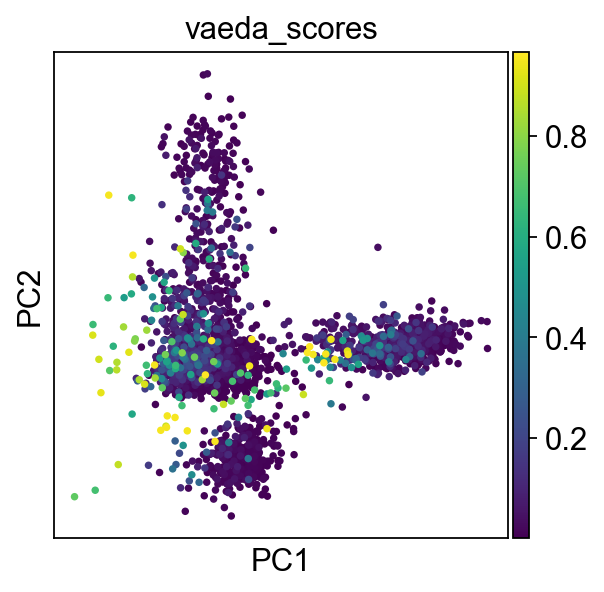

In [9]:
sc.pl.pca(adata, color='vaeda_scores')

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata,init_pos='paga', min_dist=1.0, maxiter=200)


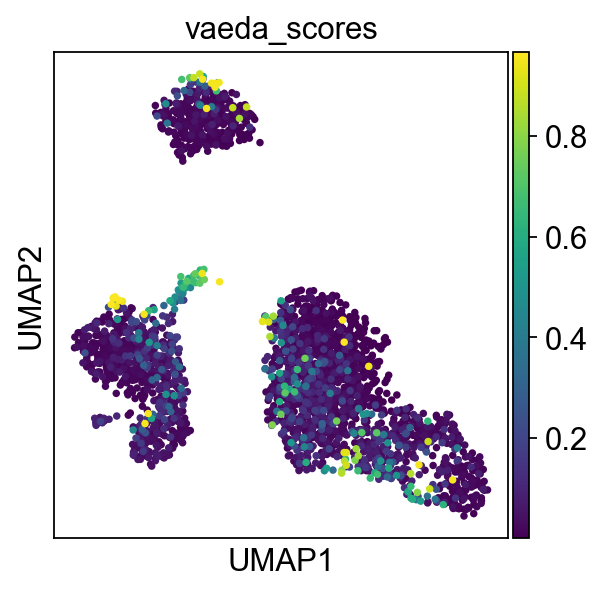

In [11]:
sc.pl.umap(adata, color=['vaeda_scores'])